In [176]:
from genomic_benchmarks.data_check import list_datasets
from genomic_benchmarks.loc2seq import download_dataset

from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

from pathlib import Path
import pandas as pd
import os

In [6]:
print(list_datasets())

download_dataset("human_ocr_ensembl", version=0)

['demo_coding_vs_intergenomic_seqs', 'dummy_mouse_enhancers_ensembl', 'human_ensembl_regulatory', 'demo_human_or_worm', 'human_enhancers_cohn', 'human_nontata_promoters', 'human_enhancers_ensembl', 'human_ocr_ensembl', 'drosophila_enhancers_stark']


TypeError: Constructor parameter should be str

In [177]:
folder = "human_ocr_ensembl"
labels = {'positive': 1, 'negative': 0}
rows = []

spark = SparkSession.builder.appName("OCR").getOrCreate()

folder = "human_ocr_ensembl"
labels = {'positive': 1, 'negative': 0}

pdf = None

for f in ('test', 'train'):
    for label, label_value in labels.items():
        path = os.path.join(folder, f, label)
        files_df = spark.read.text(f"{path}/*.txt").withColumn("is_ocr", lit(label_value))
        if pdf is None:
            pdf = files_df
        else:
            pdf = pdf.union(files_df)



AttributeError: 'DataFrame' object has no attribute 'withColumnRenamed'

In [178]:
pdf = pdf.withColumnRenamed("value", "seq")
pdf.show()
pandas_df = pdf.toPandas()

+--------------------+------+
|                 seq|is_ocr|
+--------------------+------+
|AAGATCTAAAAAAATCA...|     1|
|TATGAATATAGTACGAA...|     1|
|AGTTGTACTTCTTTTGT...|     1|
|GCAAATGACTGCCAGGG...|     1|
|TAAATGCTTTGTCCTAG...|     1|
|CCTCAATAGACAGAATT...|     1|
|CGAACGGAATCATCAAA...|     1|
|TCATATTCTGGGATTTG...|     1|
|TGCTTAATAAAAAGAGA...|     1|
|ATTTCTCCTGCAGACAG...|     1|
|CATGAAATCCGTCGTCT...|     1|
|TCTTTTTTCCAATTATT...|     1|
|GTAAGGAAAAAAAGGAA...|     1|
|CTGAGCTAAACATGGCA...|     1|
|TCAGGAGAGAATGAGGC...|     1|
|GAATCCAGGCAAGAACT...|     1|
|GCCTCCCGGGTTCACGC...|     1|
|AAGTCTTTAACACAGTA...|     1|
|GCATTCAGTTACATAAA...|     1|
|TGAACATCCTCCAGAGG...|     1|
+--------------------+------+
only showing top 20 rows



In [179]:
# download the JASPAR motifs data

from Bio import motifs
from Bio.motifs import jaspar

with open("JASPAR2024_CORE_redundant_pfms_jaspar.txt") as handle:
    motif_list = motifs.parse(handle, "jaspar")

all_consensus = []
for motif in motif_list:
    print("Consensus sequence:", motif.consensus)
    all_consensus.append(str(motif.consensus))

Consensus sequence: TATTGTGGTTA
Consensus sequence: GCCCGGGGG
Consensus sequence: CACGTG
Consensus sequence: TGCGTG
Consensus sequence: ATAAGAACACCCTGTACCCGCC
Consensus sequence: CTAGGTGTGAA
Consensus sequence: AGAGCACTGAAGCGTAACCG
Consensus sequence: TGACCTTTGAACCT
Consensus sequence: CCTGGTGACGTC
Consensus sequence: AGATGCAATCCC
Consensus sequence: TTTGGCGC
Consensus sequence: TTATGTAACAT
Consensus sequence: AAGTAGTGCCC
Consensus sequence: GAGCCGGAAG
Consensus sequence: AAGATAAGATAACA
Consensus sequence: CAAACGTAAACAAT
Consensus sequence: GTAAACAT
Consensus sequence: GGTAAGTA
Consensus sequence: TATACATA
Consensus sequence: GGATGG
Consensus sequence: GGATA
Consensus sequence: AGATAG
Consensus sequence: CAAATCACTG
Consensus sequence: TAAAGGAAGG
Consensus sequence: TATTGTTTATT
Consensus sequence: GAATGTTTGTTT
Consensus sequence: GGATGTTTGTTT
Consensus sequence: GGTTACGCAATA
Consensus sequence: GGTTAATAATTAAC
Consensus sequence: CAATATTTACTT
Consensus sequence: GCGCAGCTGCGT
Consensus se

In [195]:
df = None

In [196]:
df = pandas_df

# extract as many features as we can think of

# number of nucleotides
df['length'] = df['seq'].str.len()

# % of A, C, T and G's (and N's)
df['n_A'] = df['seq'].str.count("A") / df['length']
df['n_C'] = df['seq'].str.count("C") / df['length']
df['n_T'] = df['seq'].str.count("T") / df['length']
df['n_G'] = df['seq'].str.count("G") / df['length']
#df['n_N'] = df['seq'].str.count("N") / df['length'] # this is not needed, it is implied by the other columns

df['cpg_ratio'] = np.where(
    (df['seq'].str.count('C') * df['seq'].str.count('G')) > 0,
    (df['seq'].str.count('CG') * df['length']) / (df['seq'].str.count('C') * df['seq'].str.count('G')),
    0
)

df['motif_count'] = df['seq'].apply(lambda x: sum(x.count(motif) for motif in all_consensus))

# does it contain a stop codon within it? (TAG, TAA, TGA) ?
df['contains_stop'] = df['seq'].str.contains('TAG|TAA|TGA').astype(int)

# does it have a start codon within in (AUG) ?
#df['contains_start'] = df['seq'].str.contains('ATG').astype(int)

# GC content\
df['GC_content'] = (df['seq'].str.count("G") + df['seq'].str.count("C")) / df['length']

# motifs between positive sequences? (k-mers?)
print(df.head())

                                                 seq  is_ocr  length  \
0  AAGATCTAAAAAAATCAGCTTTTCAAAGAAGATGTATGAATGGCAA...       1     593   
1  TATGAATATAGTACGAACTTTTTTTTAACAAGACAGTGTCAAGGTC...       1     593   
2  AGTTGTACTTCTTTTGTTTCCTCTTAGCCCACCCTGAGATGGAAAT...       1     593   
3  GCAAATGACTGCCAGGGTTAAGGGCCAACTTTGATGAGTGTCAGCA...       1     593   
4  TAAATGCTTTGTCCTAGGAGTGACACATATTACTTCCATGCACAAC...       1     593   

   cpg_ratio  contains_motif  contains_stop  GC_content  motif_count  \
0   0.146420               1              1    0.305228          226   
1   0.278578               1              1    0.382799          213   
2   0.165781               1              1    0.411467          187   
3   0.118092               1              1    0.344013          147   
4   0.102048               1              1    0.448567          159   

        n_A       n_C       n_T       n_G  
0  0.340641  0.168634  0.354132  0.136594  
1  0.337268  0.173693  0.279933  0.209106  
2 

In [197]:
df.describe()

,is_ocr,length,cpg_ratio,contains_motif,contains_stop,GC_content,motif_count,n_A,n_C,n_T,n_G
count,174756.000000,174756.000000,174756.000000,174756.000000,174756.000000,174756.000000,174756.000000,174756.000000,174756.000000,174756.000000,174756.000000
mean,0.500000,326.345247,0.201315,0.999536,0.997368,0.416612,99.344847,0.291016,0.207966,0.291954,0.208646
std,0.500001,108.123061,0.386234,0.021524,0.051238,0.084803,52.485488,0.066366,0.054168,0.066540,0.054128
min,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,246.000000,0.082250,1.000000,1.000000,0.360513,62.000000,0.246753,0.171533,0.247312,0.172260
50%,0.500000,315.000000,0.167815,1.000000,1.000000,0.409894,90.000000,0.288732,0.203209,0.290192,0.204380
75%,1.000000,400.000000,0.278912,1.000000,1.000000,0.468165,126.000000,0.330986,0.239390,0.331683,0.240000
max,1.000000,593.000000,93.000000,1.000000,1.000000,0.907692,2222.000000,0.690083,0.705479,0.875887,0.675532


In [198]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import display, Image

from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split


In [199]:
train_y = df['is_ocr']
train_x = df.drop(columns = ['seq','is_ocr'], axis=1)

train_x, test_x, train_y, test_y = train_test_split(df.drop(columns = ['seq','is_ocr'], axis=1), df['is_ocr'], random_state=0, train_size = .80)

tree_clf = DecisionTreeClassifier(max_depth=2, random_state = 36)
tree_clf.fit(train_x, train_y)

param_space = {
    'max_depth': (1, 10), 
    'min_samples_split': (2, 10),
    'min_samples_leaf' : (1, 20),
    'max_features' : (1, 10),
    'min_weight_fraction_leaf' : (0, 0.5)
}

# Use BayesSearchCV to perform Latin Hypercube Sampling
opt = BayesSearchCV(tree_clf, param_space, n_iter=100, cv=5, random_state=36)
opt.fit(train_x, train_y)

# Evaluate the best model found by BayesSearchCV
best_model = opt.best_estimator_

accuracy = (test_y == best_model.predict(test_x)).sum() / len(test_y)
print(accuracy)

0.5953021286335546


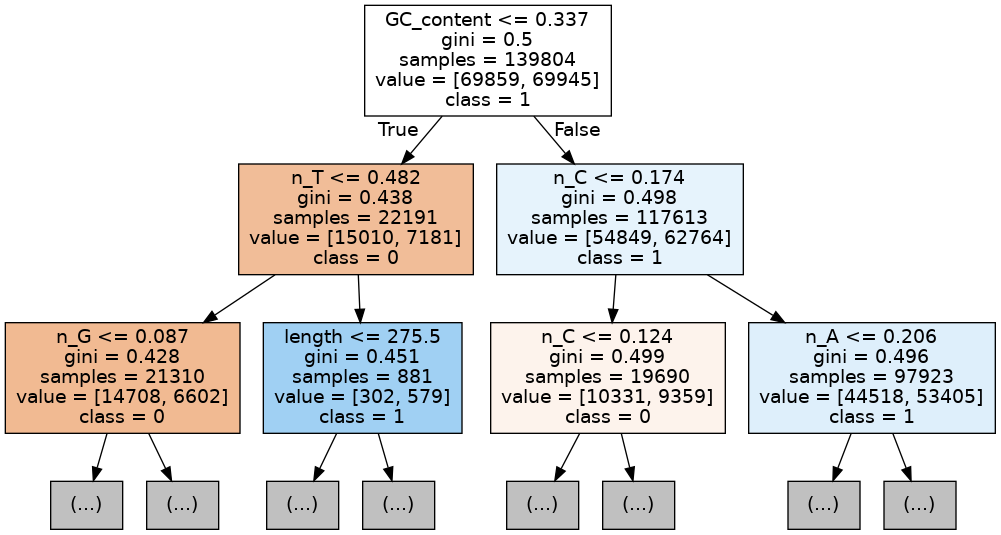

'decision_tree_graph2.png'

In [200]:
labels = train_x.columns

graph = Source(export_graphviz(best_model, 
                               feature_names=labels, 
                               class_names=train_y.unique().astype(str), 
                               max_depth=2, 
                               filled=True))

display(Image(graph.pipe(format='png')))

graph.format = 'png'  # Set format to PNG
graph.render(filename='decision_tree_graph2', directory='./', cleanup=True)  # Saves as 'decision_tree_graph.png' in current directory

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Assuming df is your DataFrame and is already defined
train, test = train_test_split(df.drop(columns=['seq']), random_state=0, train_size=.80)
print(train.shape, test.shape)

target = train.pop('is_ocr')
target_tst = test.pop('is_ocr')

param_space = {
    'eta': Real(0.01, 0.3, prior='uniform'),  
    'max_depth': Integer(3, 15),  
    'subsample': Real(0.5, 1.0, prior='uniform'),  
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),
    'colsample_bylevel': Real(0.5, 1.0, prior='uniform'),  
    'colsample_bynode': Real(0.5, 1.0, prior='uniform'),  
    'min_child_weight': Integer(1, 10), 
    'gamma': Real(0.0, 5.0, prior='uniform'), 
    'lambda': Real(0.0, 10.0, prior='uniform'), 
    'alpha': Real(0.0, 10.0, prior='uniform'), 
}

# Initialize the model
model = XGBClassifier(booster='gbtree', eval_metric='error')


# Create the BayesSearchCV object for Latin Hypercube Sampling
opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    scoring='accuracy',
    cv=5,
    n_iter=100,
    verbose=100
)

# Fit the model with Latin Hypercube Sampling
opt.fit(train, target)

# Get the best parameters and the best model
best_params = opt.best_params_
best_model = opt.best_estimator_

print("Best parameters:", best_params)

# Predictions on test set using the best model
pred_xgb = best_model.predict(test)

# Calculate accuracy for the best model
accuracy = accuracy_score(target_tst, pred_xgb)  # Compare predicted labels to true labels
print('Accuracy on test set:', accuracy)


(139804, 11) (34952, 11)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START alpha=4.422415834714859, colsample_bylevel=0.9004384613126435, colsample_bynode=0.7441597457049853, colsample_bytree=0.7980926901355444, eta=0.05525560644384841, gamma=2.0368060397160064, lambda=1.1524374797252992, max_depth=7, min_child_weight=2, subsample=0.5895694380079916
[CV 1/5; 1/1] END alpha=4.422415834714859, colsample_bylevel=0.9004384613126435, colsample_bynode=0.7441597457049853, colsample_bytree=0.7980926901355444, eta=0.05525560644384841, gamma=2.0368060397160064, lambda=1.1524374797252992, max_depth=7, min_child_weight=2, subsample=0.5895694380079916;, score=0.611 total time=   3.2s
[CV 2/5; 1/1] START alpha=4.422415834714859, colsample_bylevel=0.9004384613126435, colsample_bynode=0.7441597457049853, colsample_bytree=0.7980926901355444, eta=0.05525560644384841, gamma=2.0368060397160064, lambda=1.1524374797252992, max_depth=7, min_child_weight=2, subsample=0.58956943800

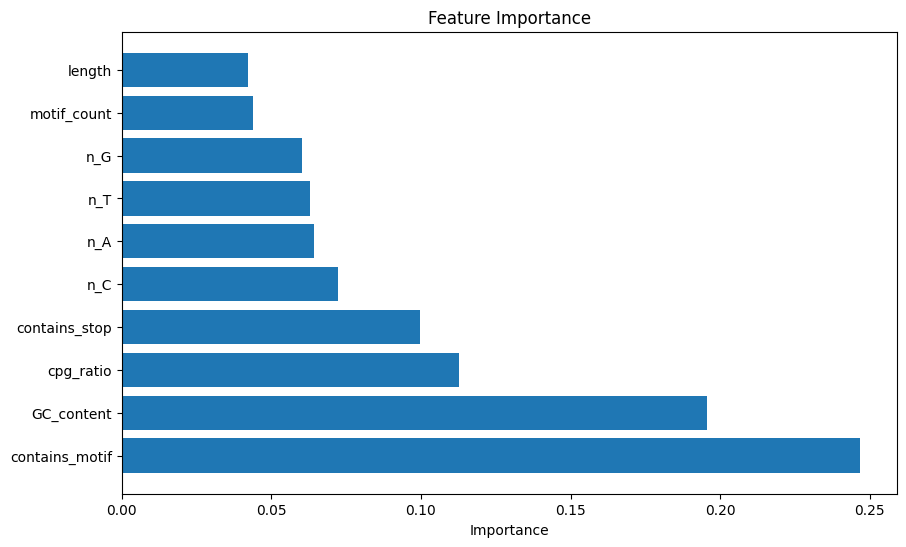

In [202]:
# Feature importance
importance_frame = pd.DataFrame({
    'Importance': best_model.feature_importances_,
    'Feature': train.columns
})

# Plotting feature importance
importance_frame.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
plt.barh(importance_frame['Feature'], importance_frame['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')

plt.savefig("feature_importance_run2.png", format="png", bbox_inches="tight")
plt.show()


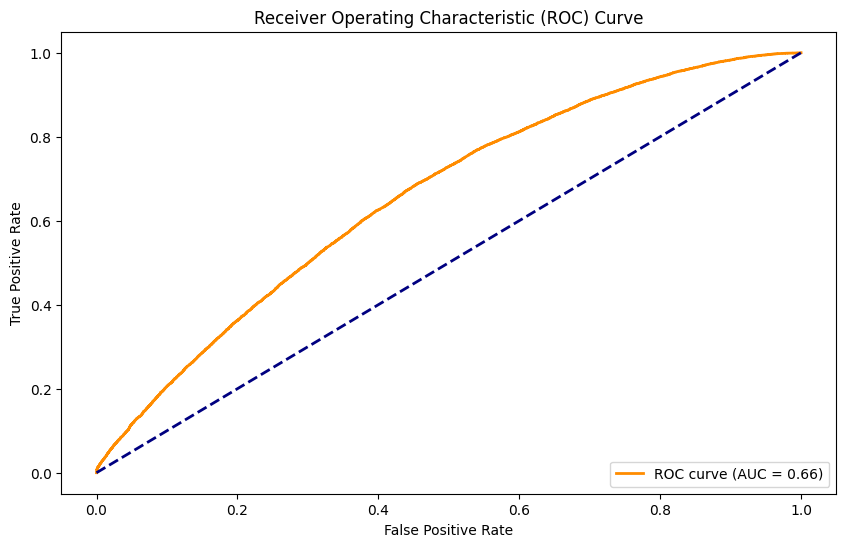

In [203]:
# AUC
from sklearn.metrics import roc_curve, auc

# Assuming `test` is your test set and `target_tst` is the true labels for the test set
# Predict probabilities for the positive class (assuming binary classification)
probs = best_model.predict_proba(test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(target_tst, probs)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig("roc_auc_run2.png", format="png", bbox_inches="tight")
plt.show()


<Figure size 800x600 with 0 Axes>

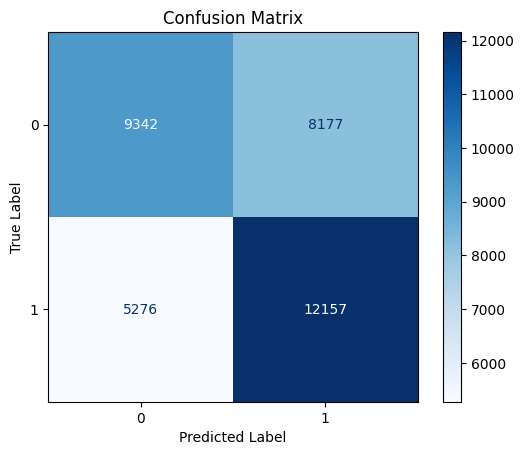

In [204]:
# confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = best_model.predict(test)

# Compute the confusion matrix
cm = confusion_matrix(target_tst, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')  # 'Blues' color map and integer format for counts
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Save and show the plot
plt.savefig("confusion_matrix_run2.png", format="png", bbox_inches="tight")
plt.show()

In [205]:
# save model
best_model.save_model('xgbclass_submission.json')
